In [1]:
from matplotlib import *
from __future__ import division
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
from scipy.integrate import solve_ivp
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.cm as cm

data from https://data.humdata.org/dataset/covid-19-mobility-italy   
paper https://www.nature.com/articles/s41597-020-00575-2   
mobility matrix, already normalized across columns => outflows sum to 1 for each patch

real mobility data

population from https://demo.istat.it/app/?i=POS 

In [2]:
pops = pd.read_csv('../data/id_provinces_it.csv').drop(['Unnamed: 0'],axis=1)
pops = pops.fillna('NA')
pops.set_index('COD_PROV',inplace=True)

In [3]:
pop_prov = pd.read_csv('../data/Popolazione residente.csv')
pop_prov = pop_prov[['Codice provincia', 'Totale']]
pop_prov.set_index('Codice provincia', inplace=True)
pop_prov

Totale
Codice provincia         
1                 2207873
2                  165878
3                  364478
4                  581676
5                  207310
...                   ...
103                153201
108                879752
109                167100
110                376561
111                329276

[107 rows x 1 columns]

In [4]:
populations = pops.merge(pop_prov, how='left', left_on='COD_PROV', right_on='Codice provincia')
#populations.to_csv('population_provinces.csv')
len(populations)

107

In [5]:
OD = pd.read_csv('../data/od_matrix_daily_flows_norm_full_2020_01_18_2020_06_26.csv')

here we select a week as a proof of concept of real mobility patterns

In [6]:
P = OD.sort_values(['p1','p2']).groupby(['p1','p2']).sum().unstack().fillna(0)
P = P['2020-01-29'].to_numpy()

<div class="alert alert-block alert-warning" style="font-size:120%">

**ATTENTION**  
the mobility matrix was computed on population samples resulting from a data collection that is not necessary representative (hence non-proportional) to the total population  

we need to project these probabilities into real provinces population, to do this we will:

* project probabilities to total trips following census population
* make it symmetric, assume all trips in one direction are also round trips
* normalize again on the outflows, to make sure the sum on j of all probabilities from i to j sums to 1


<details><summary>Hints</summary>

non-symmetric matrices will cause population mixing! 

</div>

In [7]:
# retrieve total flows from origins
p2 = P*np.array(populations.Totale)
p2[56][57] = p2[56][57]/4
p2[57][56] = p2[57][56]/4
# the original matrix is directed, make it symmetric or populations will be mixed!
OD_matrix = np.round((p2+p2.T)/2)

# now normalize again on the outflows
row_sums = OD_matrix.sum(axis=1, keepdims=True)
# Transition matrix for mobility between patches (Markovian)
P = OD_matrix / row_sums

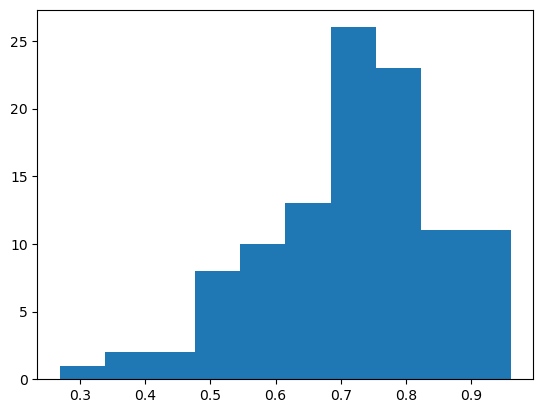

In [8]:
plt.hist(np.diag(P));
plt.show()

maps from https://public.opendatasoft.com/explore/dataset/georef-italy-provincia/information/

In [9]:
map_prov = gpd.read_file('../data/georef-italy-provincia/georef-italy-provincia-millesime.shp')
map_prov = map_prov[['prov_sigla','geometry']]
map_prov.prov_sigla.unique().size

107

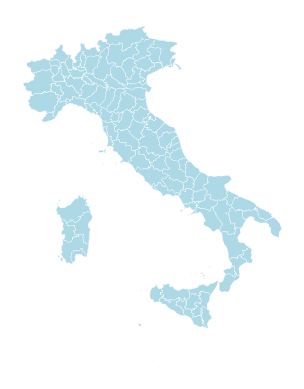

In [10]:

map_prov.plot(edgecolor='w',facecolor='lightblue',lw=.2)
plt.axis('off')
plt.show()

### now we can run our model!

In [16]:
# set population parameters
population = np.array(populations.Totale)
population_names = np.array(populations.DEN_PCM)
population_shortnames = np.array(populations.SIGLA)

# parameters
num_patches = len(populations)
beta = 0.3     # Infection rate
gamma = 0.2      # Recovery rate

# set n of seeds
seed = 0
nseeds = 10

# Time span for simulation
t_max = 200
t_span = (0, t_max)
t_eval = np.linspace(0, t_max-1, t_max*1)
dt = t_eval[1]-t_eval[0]

subpopulation_R0 = beta/gamma

#upper bound of final attack ratio, asymptotic state assuming R(inf) = N and initial S = N
attack_ratio = population*(1 - np.exp(-subpopulation_R0))
print(subpopulation_R0)

1.4999999999999998


### write the force of infection  
write the force of infection for the reaction process within the patch

$\Large \lambda_i = \beta \ {\frac{I_i}{N_i} }$

In [18]:
# Force of infection function
def force_of_infection(beta, I, P, N):
    return beta * I / N 

In [19]:

# Initial conditions (S, I, R for each patch)
S0 = np.array(population) # initial susceptible populations
S0[seed] -= nseeds   # remove seeds from seed susceptible populations

I0 = np.zeros(num_patches) # initial infected populations
I0[seed] = nseeds          # seeds
R0 = np.zeros(num_patches) # initial recovered populations

# Model system of ODEs
def sir_model(t, y, beta, gamma, P, population):
    # Reshape the state vector y into S, I, R for each patch
    S = y[:num_patches] #top rows
    I = y[num_patches:2*num_patches] #middle rows
    R = y[2*num_patches:] #bottom rows
    
    # Calculate the force of infection for each patch
    lambda_i = force_of_infection(beta, I, P, population)
    
    # Compute the derivatives for each patch
    dSdt = - S * lambda_i + np.dot(S, P) - S * np.sum(P, axis=1)
    dIdt = S * lambda_i - gamma  * I + np.dot(I, P) - I * np.sum(P, axis=1)
    dRdt = gamma * I + np.dot(R, P) - R * np.sum(P, axis=1)
    
    # Concatenate the derivatives into a single vector
    return np.concatenate([dSdt, dIdt, dRdt])

# Initial state vector
y0 = np.concatenate([S0, I0, R0]) #top rows = S, second rows = I, bottom rows = R

# Solve the system of ODEs
solution = solve_ivp(sir_model, t_span, y0, args=(beta, gamma, P, population), t_eval=t_eval)

# Extract results
S, I, R = solution.y[:num_patches], solution.y[num_patches:2*num_patches], solution.y[2*num_patches:]



<Figure size 1000x600 with 0 Axes>

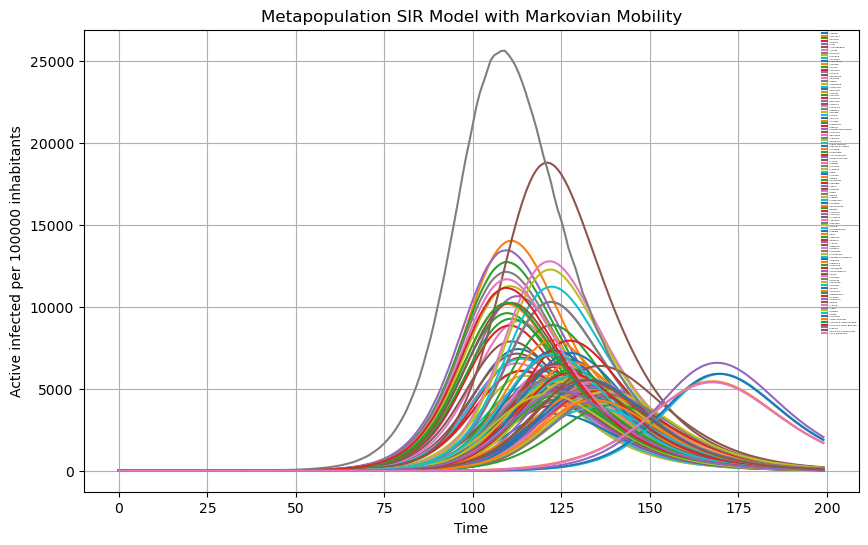

In [20]:
# Plot the results
plt.figure(figsize=(10, 6))
incidence_scale = 100000

# Plot Susceptible, Infected, and Recovered over time
for i in range(num_patches):
    plt.plot(solution.t, incidence_scale * I[i]/population[i], label=f'I '+population_names[i])

plt.xlabel('Time')
plt.ylabel('Active infected per '+str(incidence_scale)+' inhabitants')
plt.legend(frameon=False, fontsize=1.7)
plt.title('Metapopulation SIR Model with Markovian Mobility')
plt.grid(True)
plt.show()

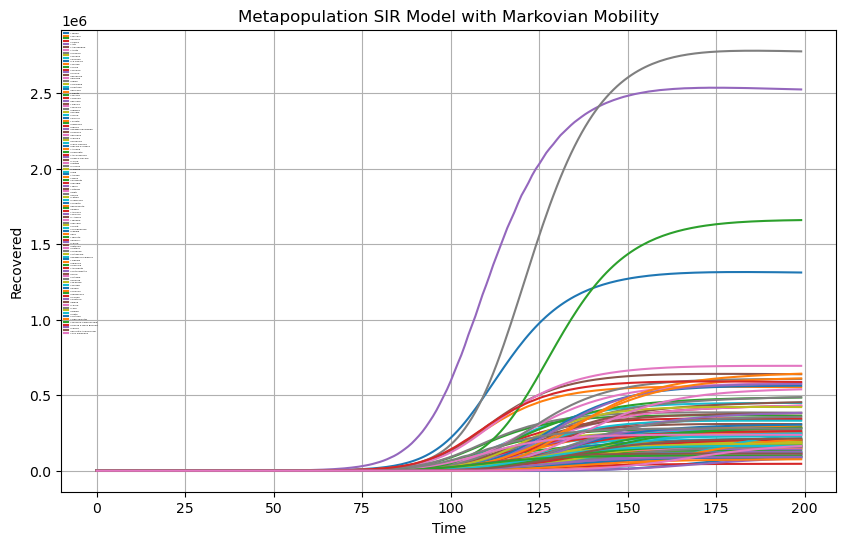

In [21]:
# Plot the results
plt.figure(figsize=(10, 6))

# Plot Susceptible, Infected, and Recovered over time
for i in range(num_patches):

    plt.plot(solution.t, R[i], label=f'I '+population_names[i])
    #plt.axhline(attack_ratio[i] ,ls='--', color='grey')

plt.xlabel('Time')
plt.ylabel('Recovered')
plt.legend(frameon=False, fontsize=1.7)
plt.title('Metapopulation SIR Model with Markovian Mobility')
plt.grid(True)
plt.show()

### Let's map the active infected every day

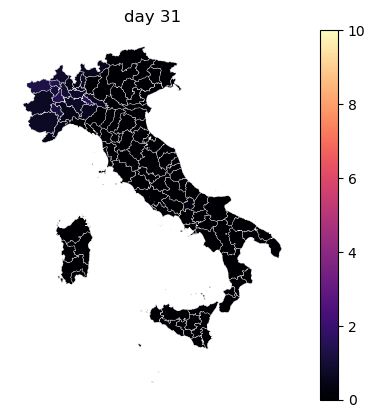

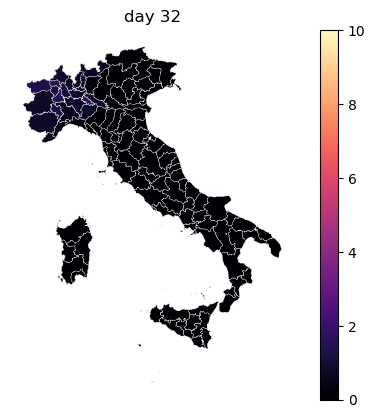

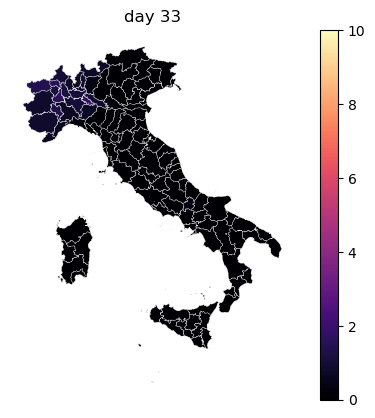

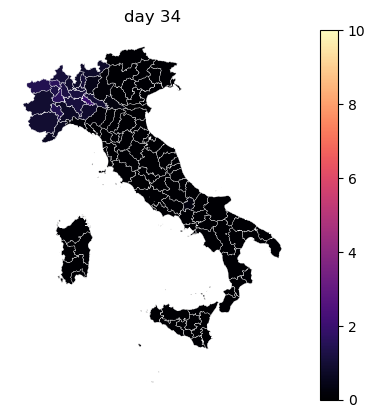

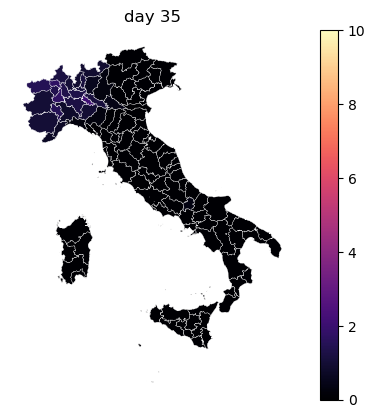

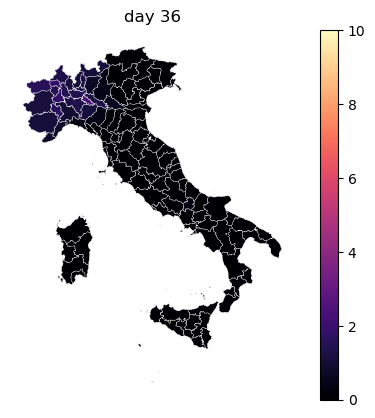

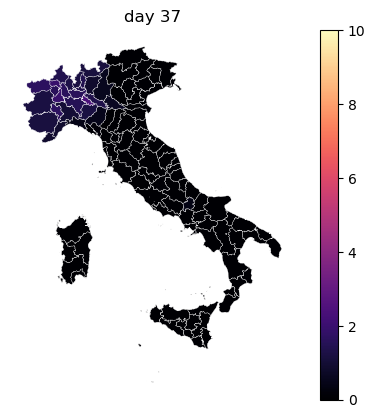

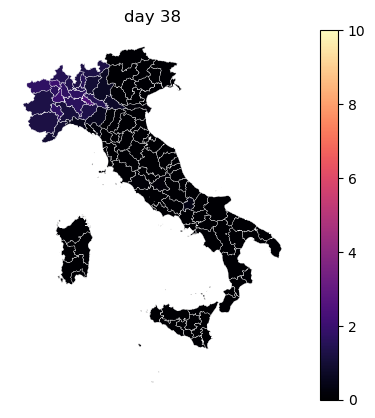

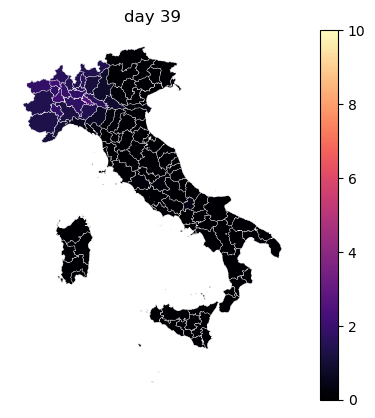

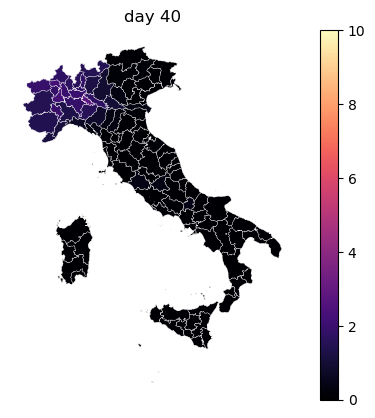

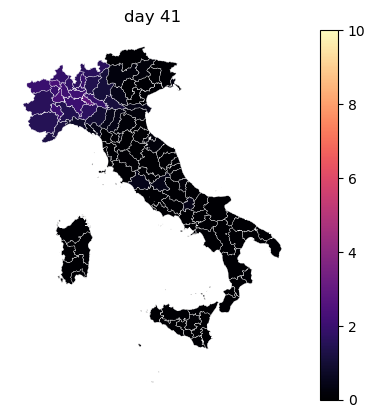

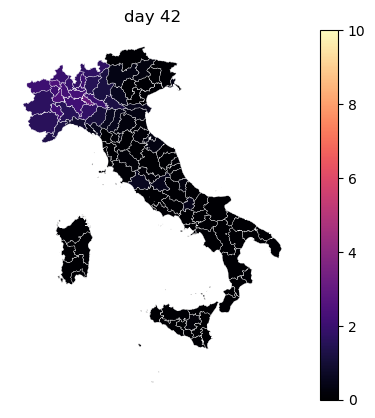

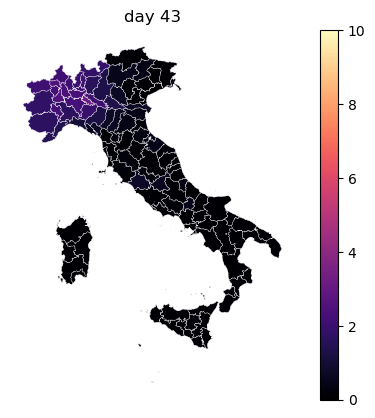

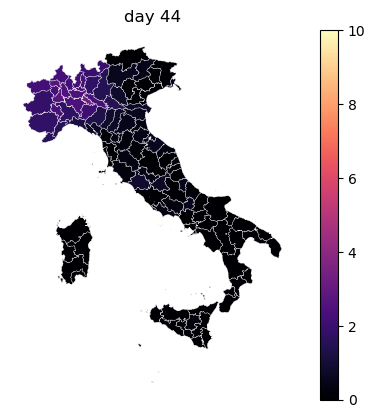

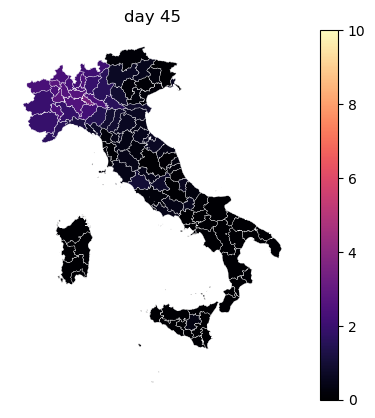

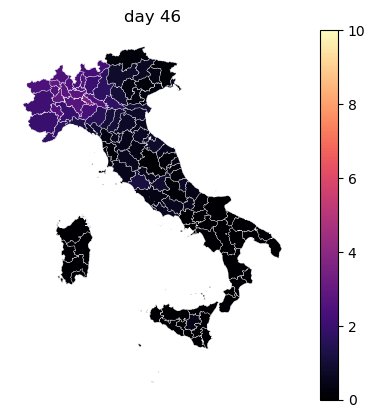

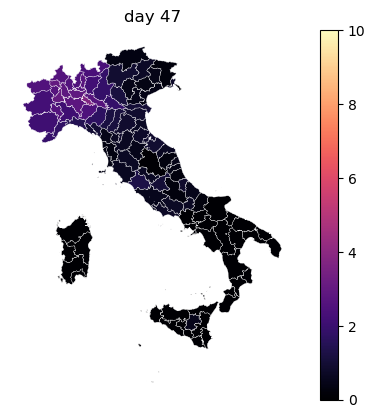

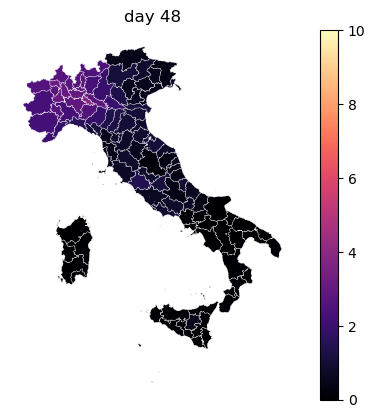

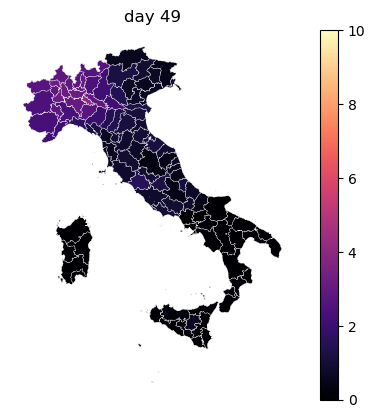

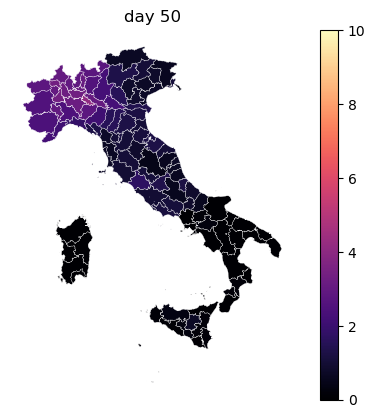

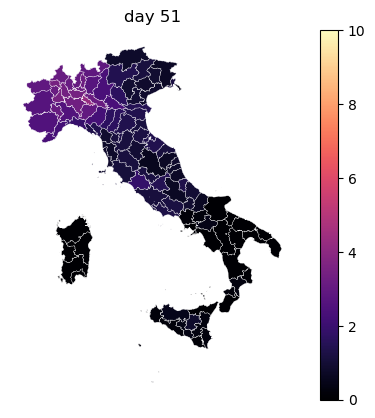

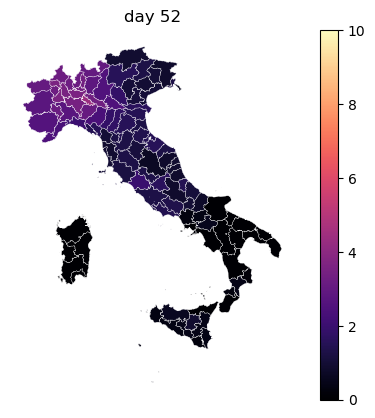

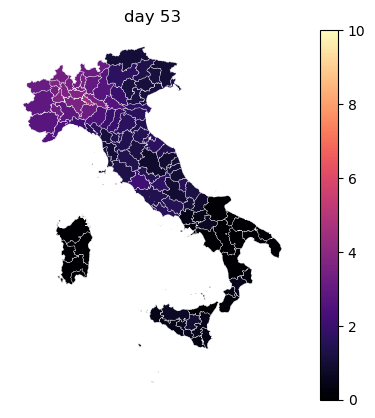

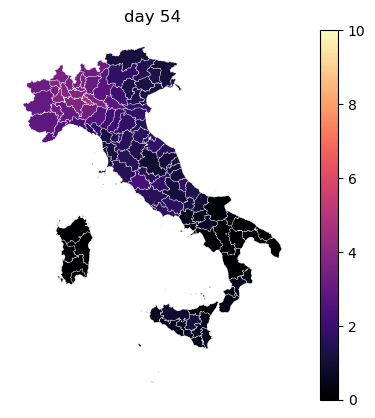

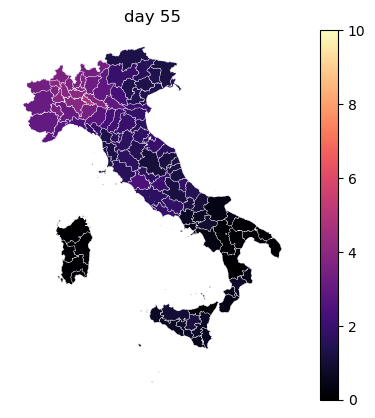

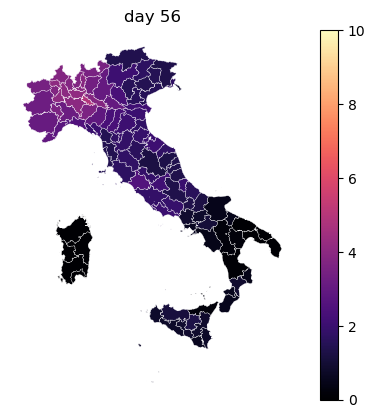

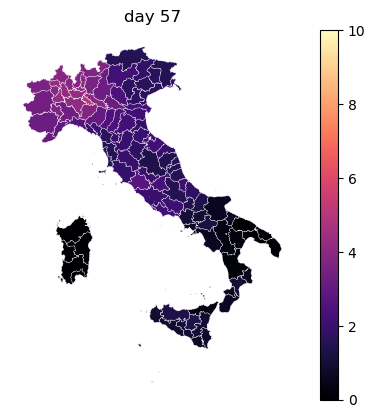

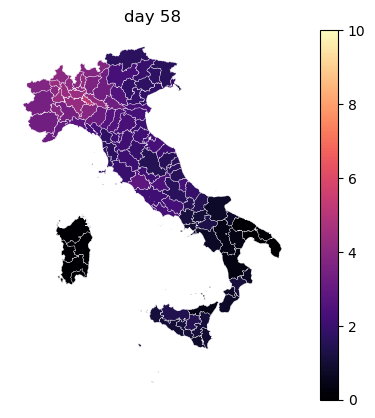

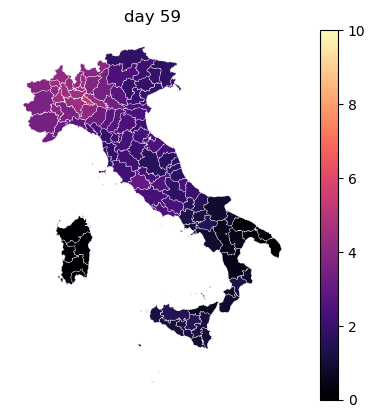

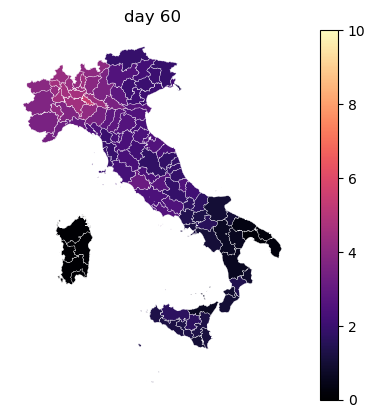

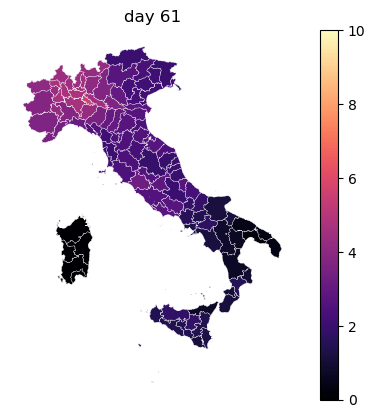

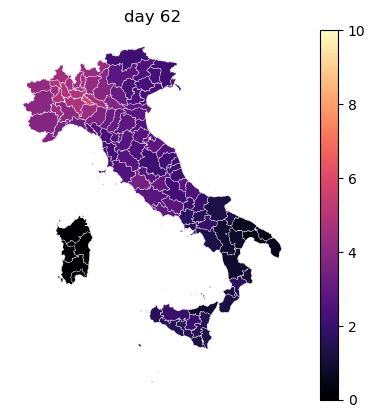

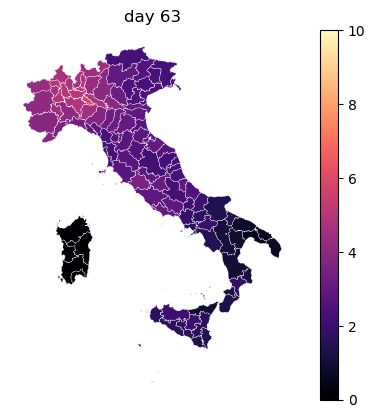

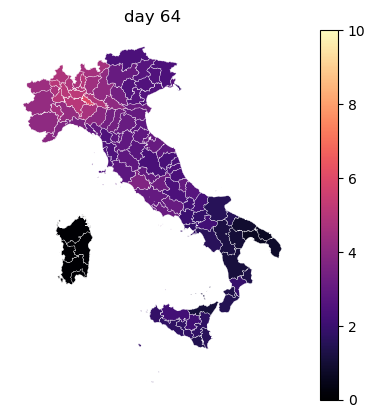

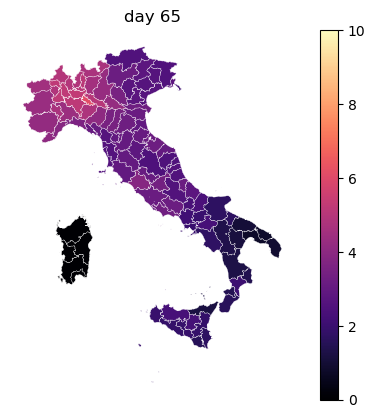

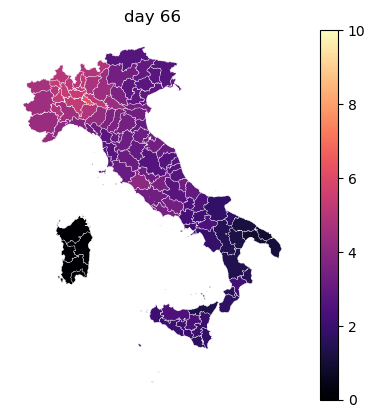

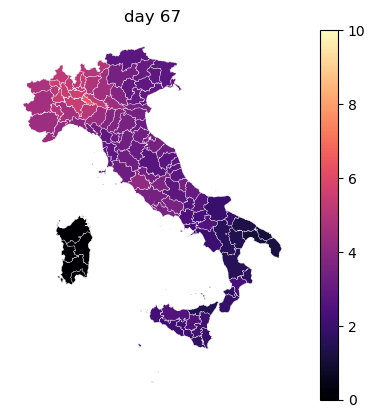

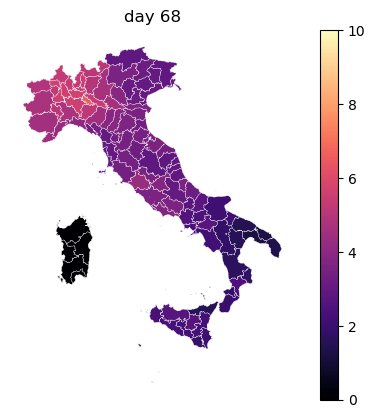

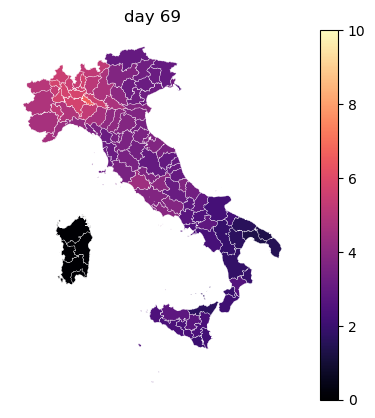

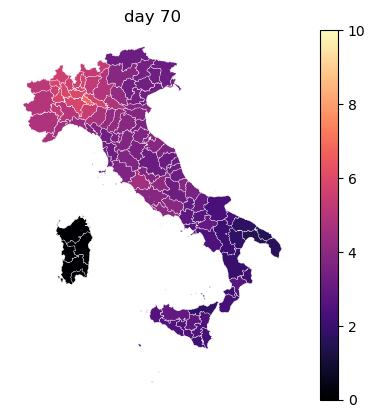

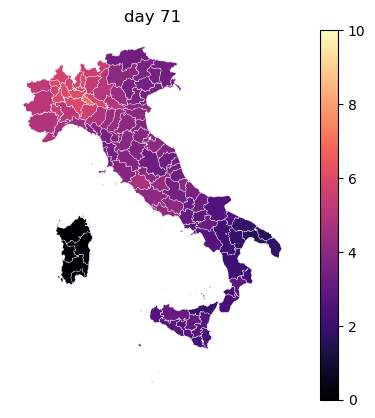

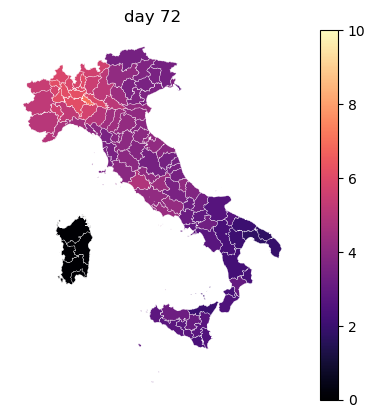

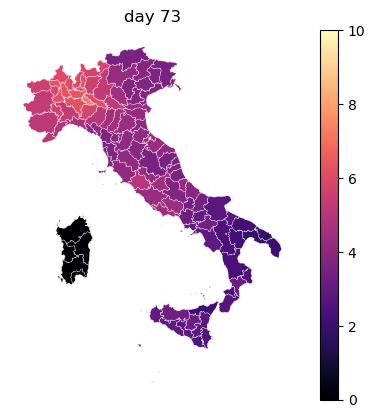

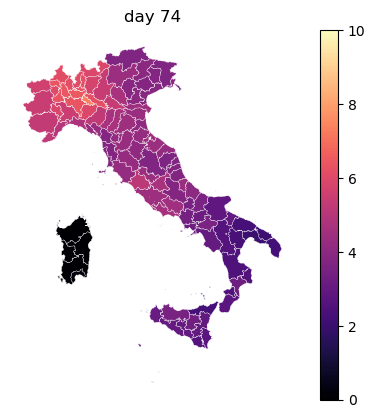

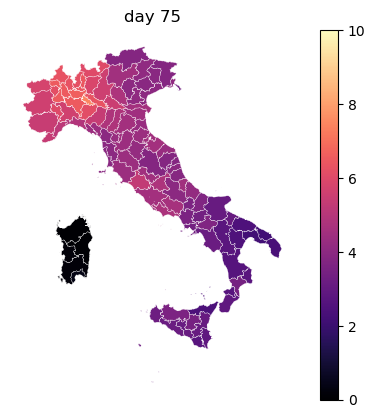

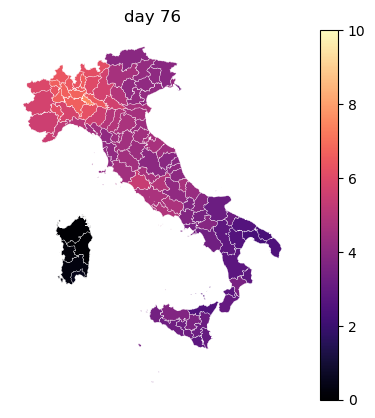

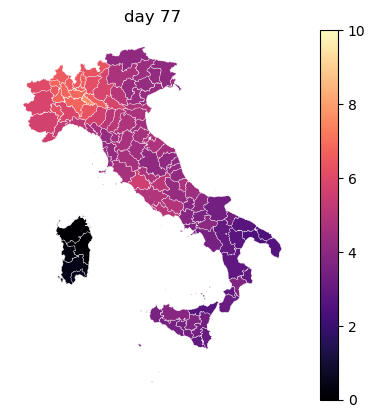

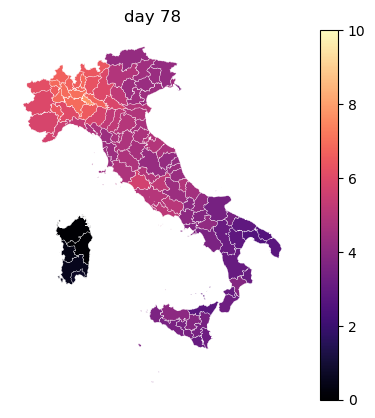

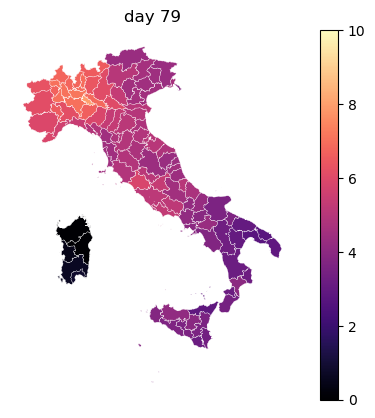

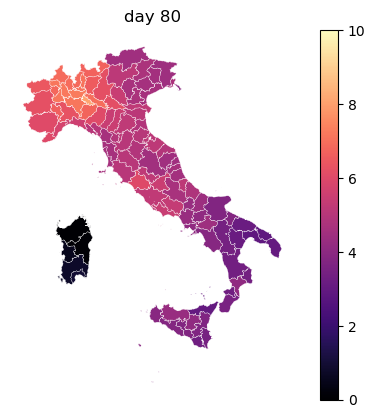

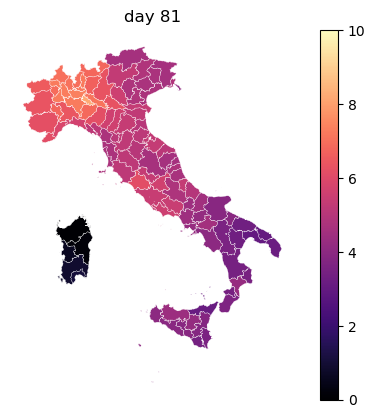

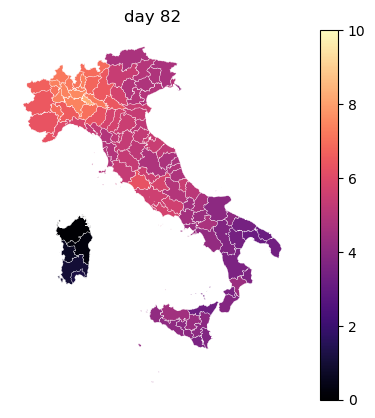

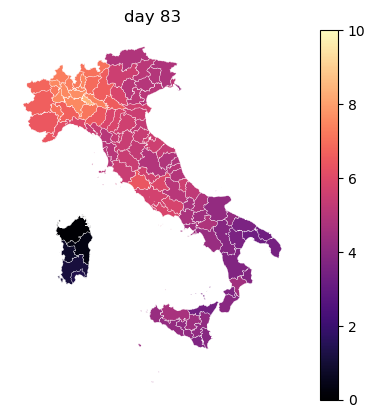

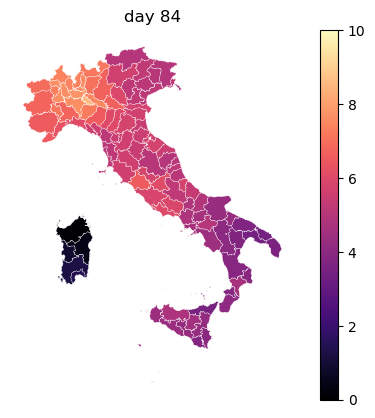

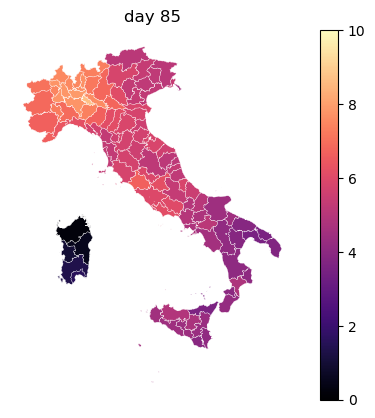

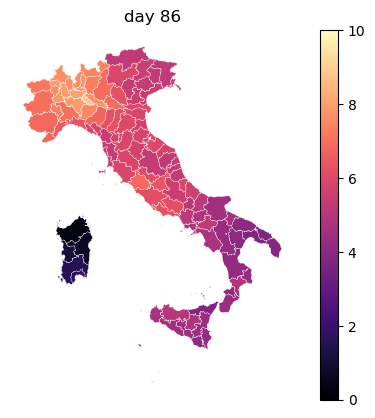

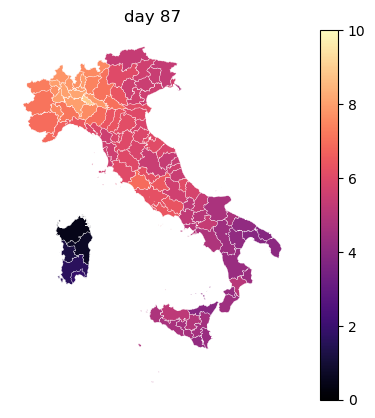

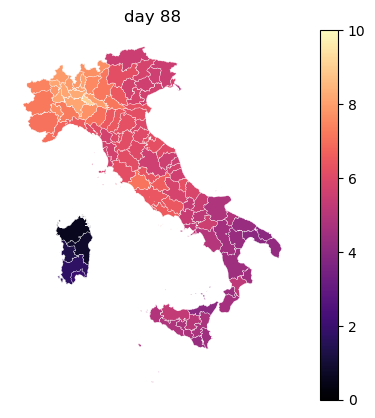

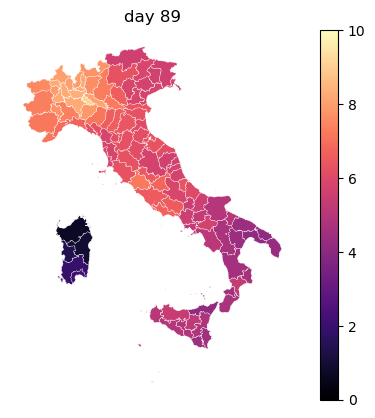

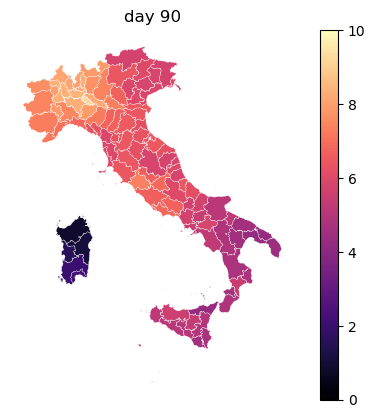

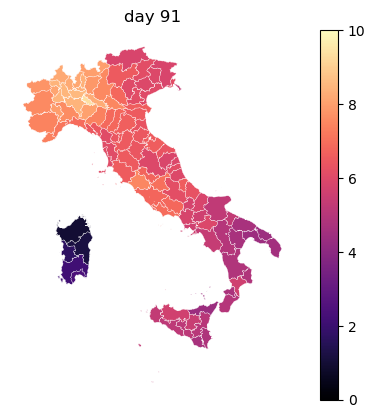

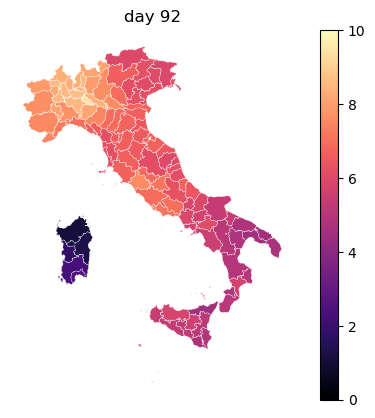

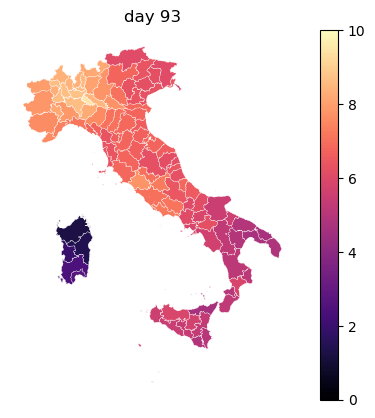

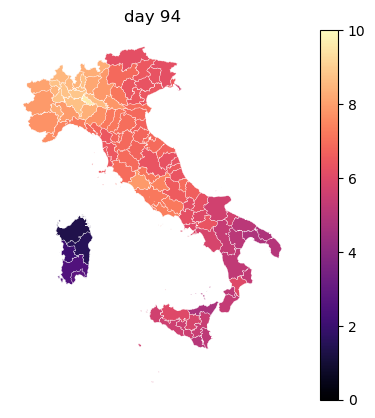

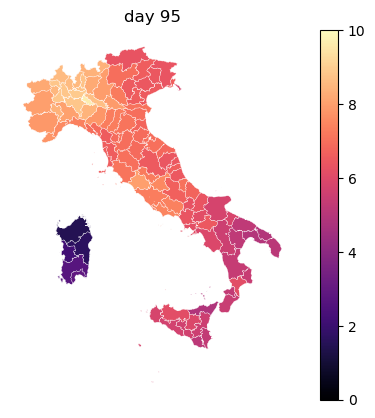

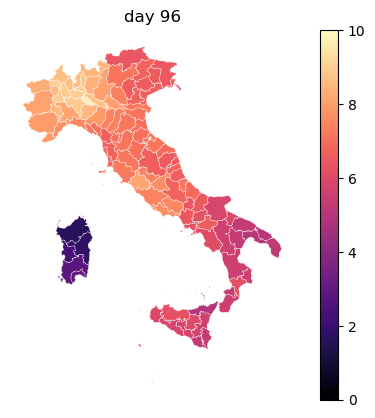

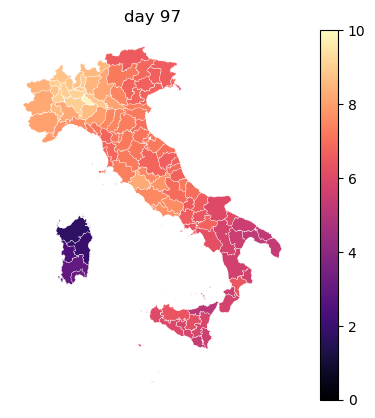

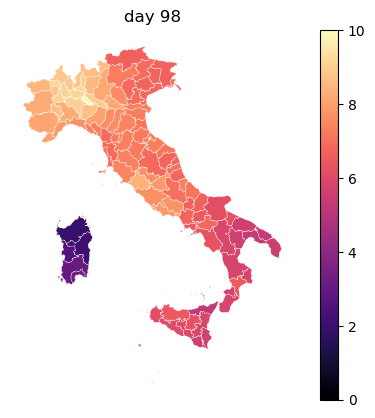

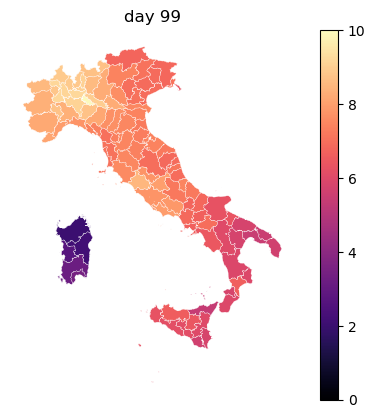

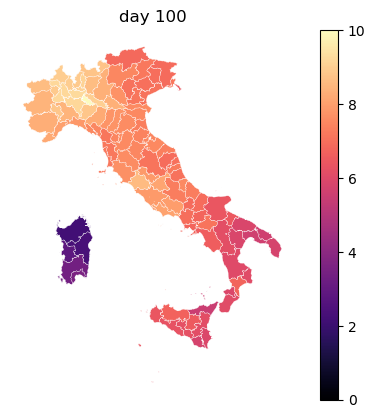

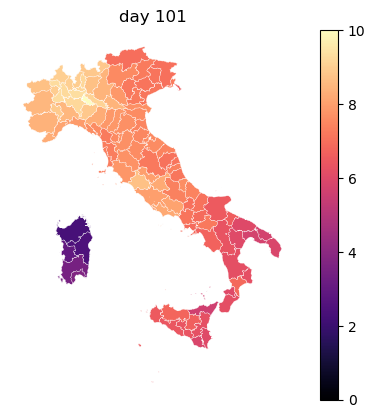

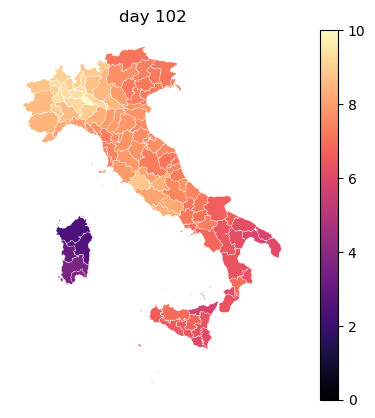

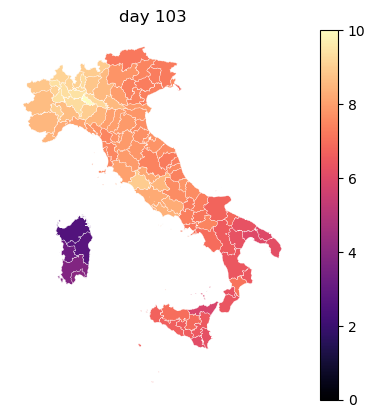

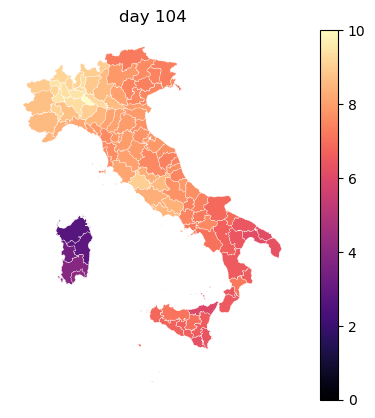

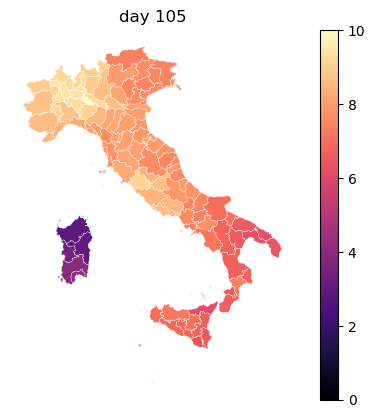

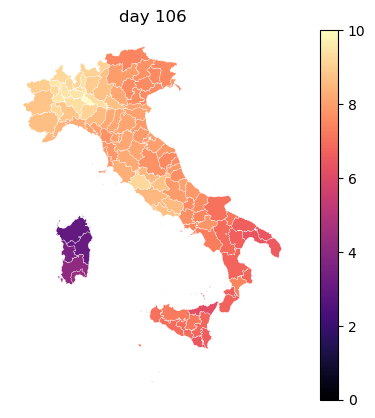

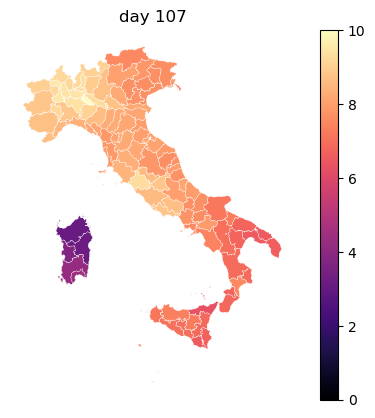

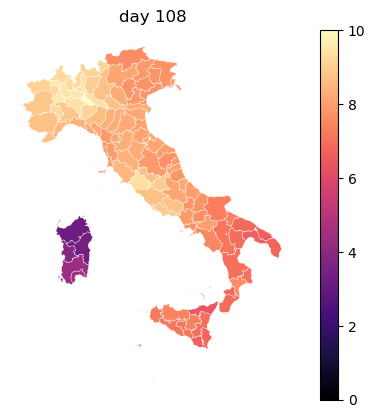

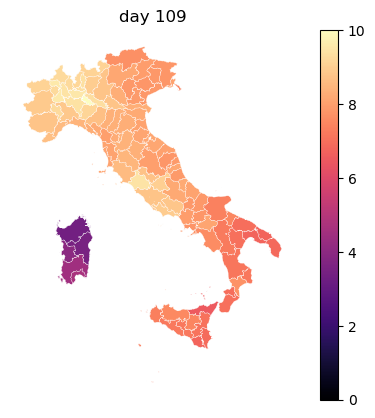

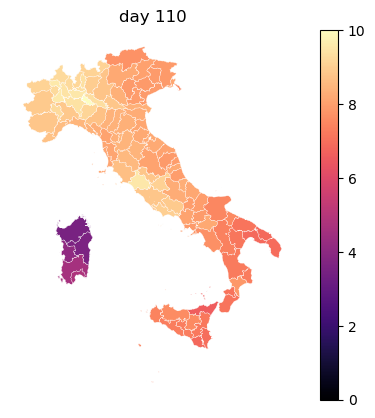

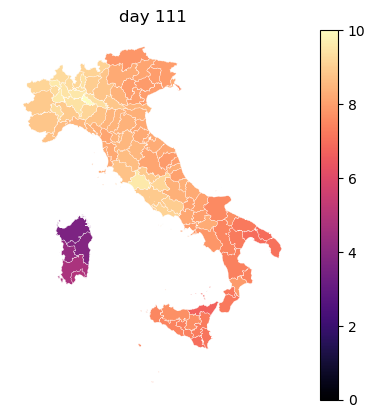

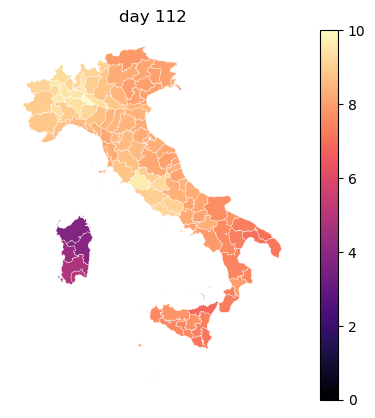

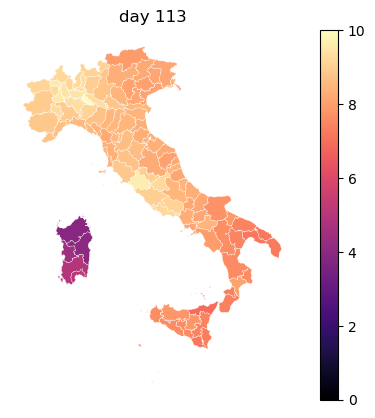

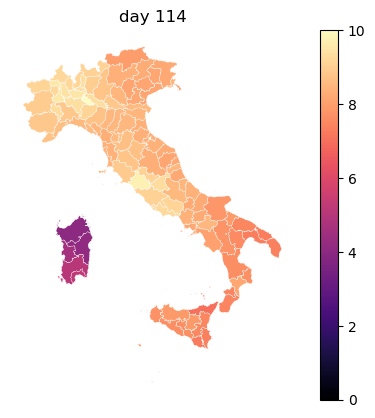

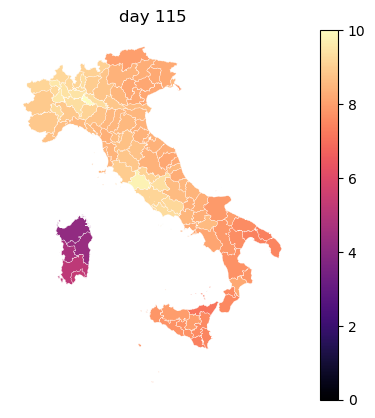

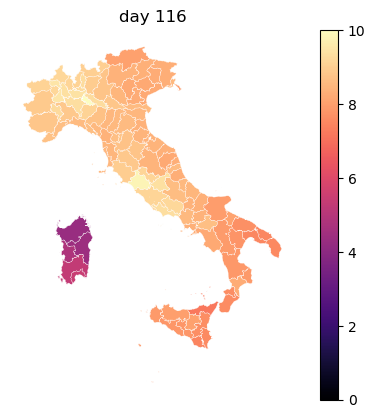

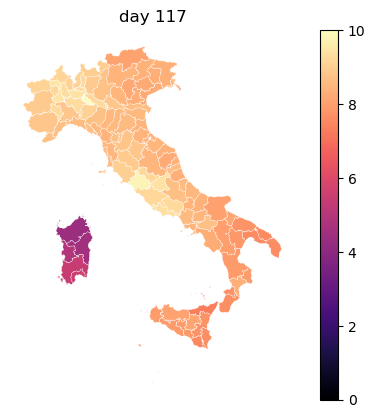

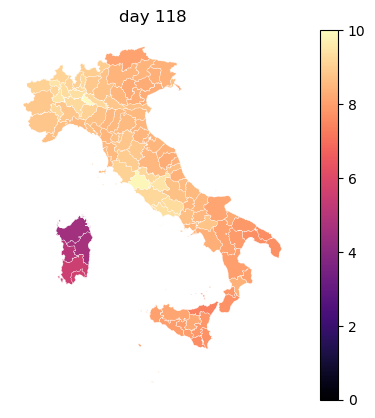

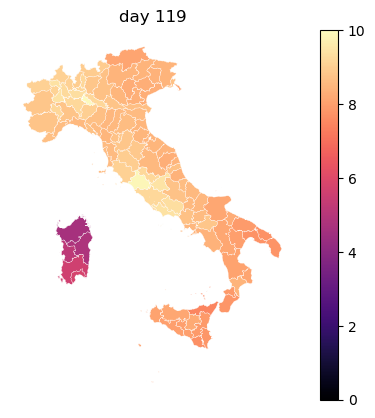

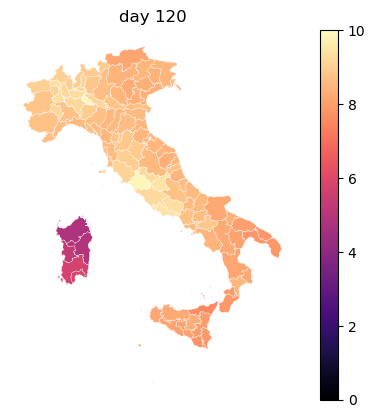

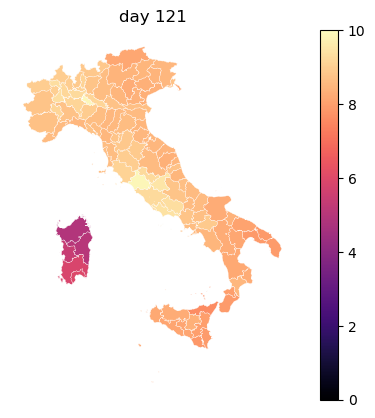

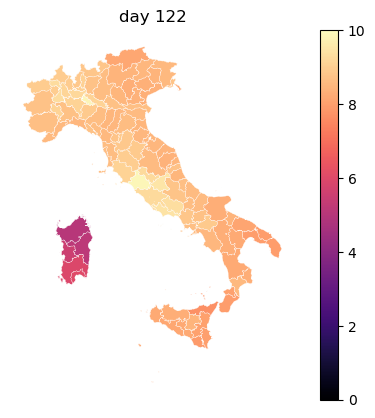

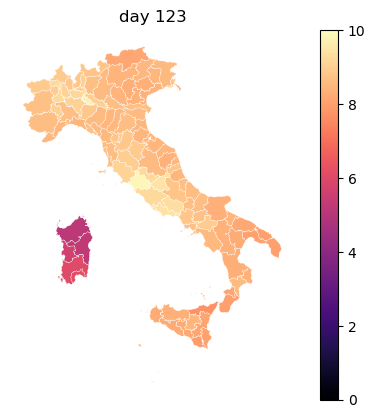

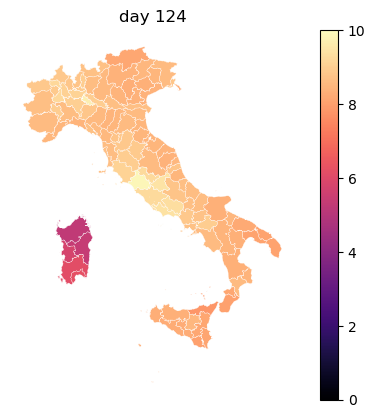

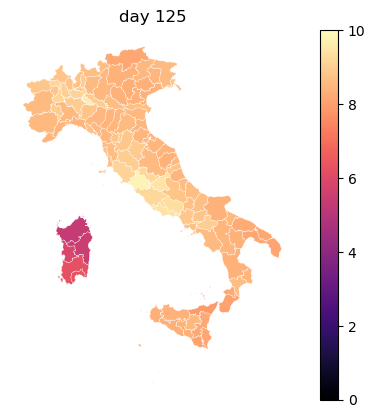

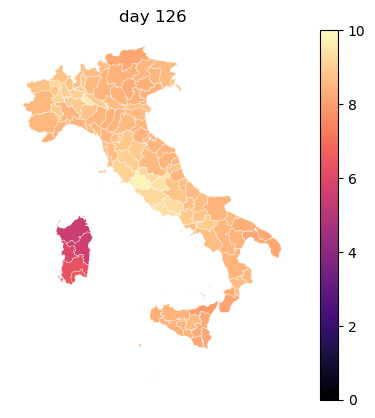

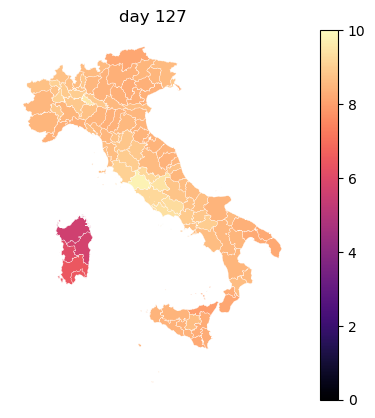

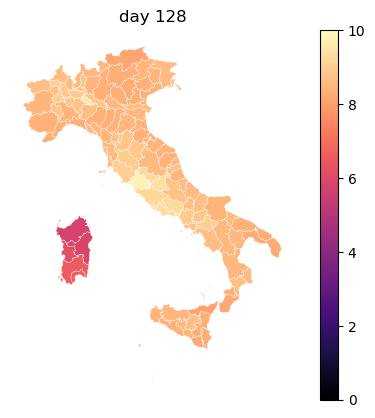

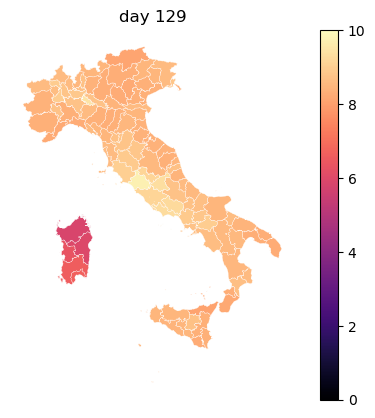

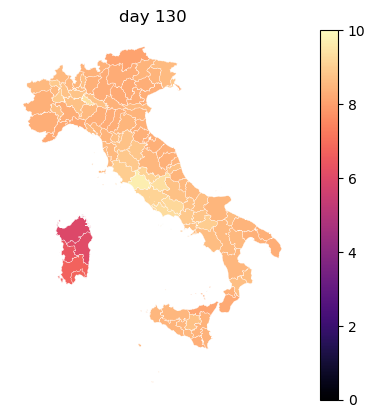

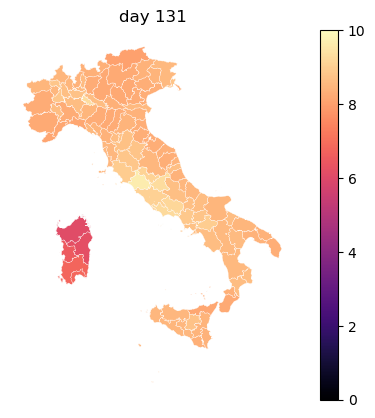

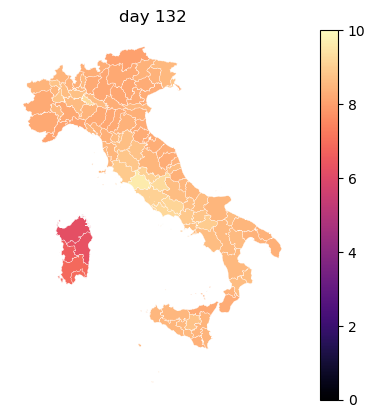

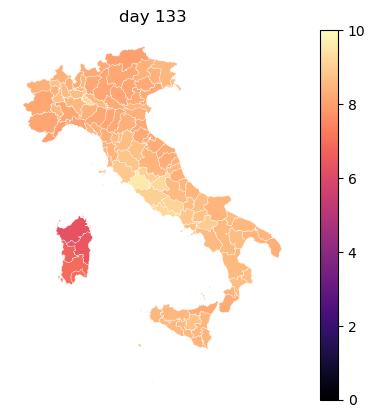

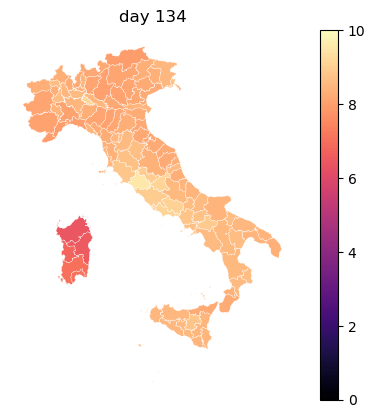

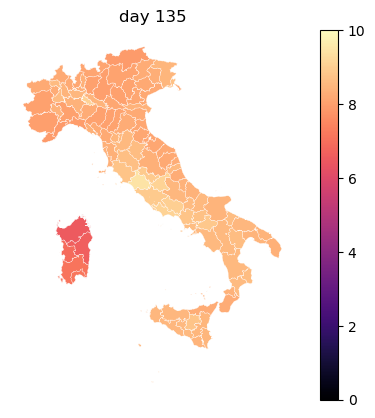

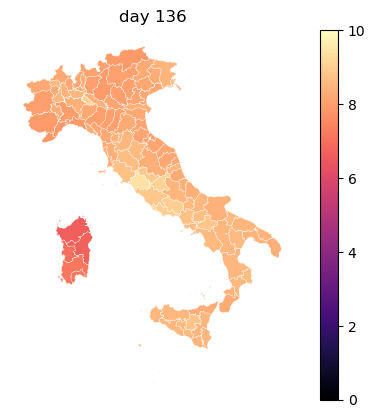

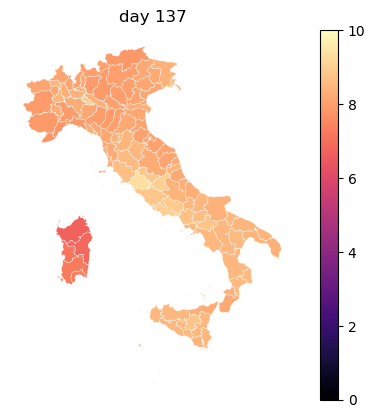

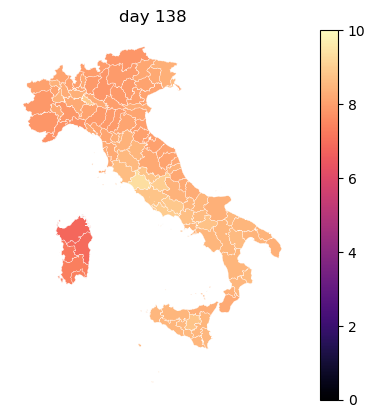

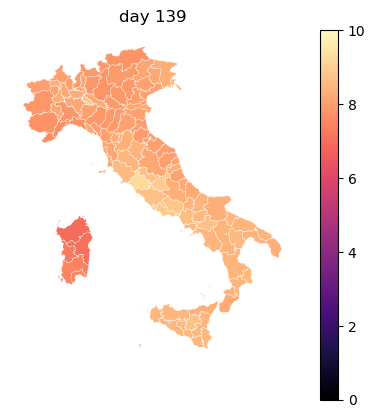

In [22]:

vmax = 10
for t in range(t_max):
    if t>30 and t<140:
        df0 = pd.DataFrame(columns=['prov','active cases'])
        for i in range(num_patches):
            #print((1+I[i][t]) * incidence_scale / population[i] )
            df0.loc[i] = [population_shortnames[i], np.log((1+I[i][t]) * incidence_scale / population[i] ) ]
        map_cases = map_prov.merge(df0, how='left', left_on='prov_sigla', right_on='prov')
        
        fig,ax=plt.subplots()
        map_cases.plot(column='active cases',edgecolor='w',lw=.2,cmap=cm.magma, legend=True, vmin=0, vmax=vmax,ax=ax)
        plt.axis('off')
        ax.set_title('day '+str(t))
        plt.show()
        

### Task: use the non-markovian mobility model instead and check how longer it takes to have similar outcomes

### Task II: impose national lockdown and estimate fraction of cases averted

### Task III: impose lockdown only in north regions 